In [ ]:
import multiprocessing as mp
import os
import re
import time
from functools import partial
from itertools import product
from multiprocessing import Pool, cpu_count
from typing import Iterable, List, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from graph_state.graph_state import *
from matplotlib.ticker import (  # Added FuncFormatter
    FuncFormatter,
    LogFormatterSciNotation,
    MaxNLocator,
    MultipleLocator,
)

In [2]:
# --- Plotting Functions ---

def calculate_metrics_from_diags(diags_array: np.ndarray, true_diags: np.ndarray):
    """
    Calculates various metrics from diagonal measurements for each repeat.
    
    Args:
        diags_array: A 2D array of shape (num_repeats, num_diagonals).
        true_diags: A 1D array of the true diagonal values.
        input_fidelity: The fidelity value used as input for this experiment.

    Returns:
        A tuple containing three 1D arrays (one value per repeat):
        - delta_a_norm_2: The L2 norm of the difference vector.
        - estimated_fidelities: The calculated fidelity for each repeat.
        - delta_fidelities: The difference between input and estimated fidelity.
    """
    # Ensure true_diags can be broadcast for subtraction
    original_true_diags = np.array(true_diags)
    if true_diags.ndim == 1:
        true_diags = true_diags[np.newaxis, :]

    # L2 norm of the difference vector (delta_a) for each repeat
    delta_a_norm_2 = np.linalg.norm(diags_array - true_diags, axis=1)
    
    # # Estimated fidelity (example: 1 - MSE)
    # mse = np.mean((diags_array - true_diags)**2, axis=1)
    # estimated_fidelities = 1 - mse
    estimated_fidelities = diags_array[:, 0]
    
    # Delta fidelity
    # print(np.array([true_diags[0] for _ in estimated_fidelities]))
    # print(f'estimated fidelity {estimated_fidelities}')
    delta_fidelities = np.abs(np.array([original_true_diags[0] for _ in estimated_fidelities]) - estimated_fidelities)
    
    return delta_a_norm_2, delta_fidelities


def load_data_for_plotting(output_dir: str, file_prefix: str):
    """Loads all .npy files, calculates metrics, and returns pandas DataFrames."""
    all_data = []
    
    file_pattern = re.compile(
        rf"{file_prefix}_(\d+)q_F([\d.]+)_err_(.*?)_shots_(\d+).npy"
    )

    for filename in os.listdir(output_dir):
        match = file_pattern.match(filename)
        if match:
            qubits, F_str, err, shots = match.groups()
            qubits = int(qubits)
            input_F = float(F_str)
            
            filepath = os.path.join(output_dir, filename)
            diags_data = np.load(filepath)
            true_diags = get_true_diagonals(qubits, input_F, err)
            
            # Calculate all metrics for the loaded data
            delta_norms, delta_fidelities = calculate_metrics_from_diags(diags_data, true_diags)
            
            # Append one record per repeat
            for i in range(len(delta_norms)):
                all_data.append({
                    "prefix": file_prefix,
                    "qubits": int(qubits),
                    "input_fidelity": input_F,
                    "error_model": err,
                    "total_shots": int(shots),
                    "diag_sanity": np.sum(diags_data[i]),
                    "repeats": i,
                    "delta_a_norm_2": delta_norms[i],
                    "est_fidelity": diags_data[i][0],
                    "delta_fidelity": delta_fidelities[i]
                })
                
    if not all_data:
        return pd.DataFrame(), pd.DataFrame()
        
    df = pd.DataFrame(all_data)
    
    return df


def load_all_fidelity_data(output_dir: str):
    """
    Loads all 'bell_fidelity' data, calculates metrics, and returns a DataFrame.
    """
    all_data = []
    file_pattern = re.compile(
        r"bell_fidelity_(\d+)q_F([\d.]+)_err_(.*?)_shots_(\d+)_numstab_(\d+).npy"
    )
    
    if not os.path.isdir(output_dir):
        print(f"Warning: Fidelity data directory '{output_dir}' not found. Returning empty DataFrame.")
        return pd.DataFrame()

    for filename in os.listdir(output_dir):
        match = file_pattern.match(filename)
        if match:
            qubits, F_str, err, shots, numstab = match.groups()
            qubits = int(qubits)
            input_F = float(F_str)
            shots = int(shots)
            numstab = int(numstab)
            
            filepath = os.path.join(output_dir, filename)
            fidelities_array = np.load(filepath)
            
            for i, est_fidelity in enumerate(fidelities_array):
                all_data.append({
                    "qubits": qubits,
                    "input_fidelity": input_F,
                    "error_model": err,
                    "shots": shots,
                    "numstab": numstab,
                    "repeat": i,
                    "estimated_fidelity": est_fidelity,
                    "fidelity_error": np.abs(est_fidelity - input_F) # (est - true)
                })
    return pd.DataFrame(all_data)

In [4]:
# a = np.array([i for i in range(20)]).reshape(5, 4)
# a, a[:, 0]

# file_prefix = 'tomo'
# output_dir = 'tomo_data'
# file_pattern = re.compile(
#         rf"{file_prefix}_(\d+)q_F([\d.]+)_err_(.*?)_shots_(\d+).npy"
#     )
# # file_pattern = re.compile(
# #         r"tomo_(\d+)q_F([\d.]+)_err_(.*?)_shots_(\d+).npy"
# #     )
# for filename in os.listdir(output_dir):
#     # print(filename)
#     match = file_pattern.match(filename)
#     if match:
#         qubits, F_str, err, shots = match.groups()
#         print(qubits, F_str, err, shots)

tomo_df = load_data_for_plotting('tomo_data', 'tomo')
bell_diag_df = load_data_for_plotting('bell_diag_data', 'bell_diag')
# df_exp1 = tomo_df[tomo_df['input_fidelity'] == 0.9].copy()

# bell_diag_df = load_data_for_plotting('bell_diag_data', 'bell_diag')
# df_exp1 = bell_diag_df[bell_diag_df['input_fidelity'] == 0.9].copy()
# df_exp1

combined_df = pd.concat([tomo_df, bell_diag_df], ignore_index=True)

# Filter data for the two main experiment types
df_exp1 = combined_df[combined_df['input_fidelity'] == 0.9].copy()
df_exp1 = df_exp1[df_exp1['qubits'] == 8].copy()
df_exp1 = df_exp1[df_exp1['prefix'] == 'bell_diag'].copy()
df_exp1

,prefix,qubits,input_fidelity,error_model,total_shots,diag_sanity,repeats,delta_a_norm_2,est_fidelity,delta_fidelity
8325,bell_diag,8,0.9,depolarizing,13895,1.0,0,0.003934,0.897659,0.002341
8326,bell_diag,8,0.9,depolarizing,13895,1.0,1,0.004243,0.896938,0.003062
8327,bell_diag,8,0.9,depolarizing,13895,1.0,2,0.003988,0.897179,0.002821
8328,bell_diag,8,0.9,depolarizing,13895,1.0,3,0.002850,0.899503,0.000497
8329,bell_diag,8,0.9,depolarizing,13895,1.0,4,0.003147,0.899822,0.000178
...,...,...,...,...,...,...,...,...,...,...
16170,bell_diag,8,0.9,depolarizing,15999,1.0,20,0.002880,0.900807,0.000807
16171,bell_diag,8,0.9,depolarizing,15999,1.0,21,0.005137,0.895726,0.004274
16172,bell_diag,8,0.9,depolarizing,15999,1.0,22,0.002597,0.900183,0.000183
16173,bell_diag,8,0.9,depolarizing,15999,1.0,23,0.003743,0.902472,0.002472



Saved comparison plot to: plots/comparison_plot_8q.png


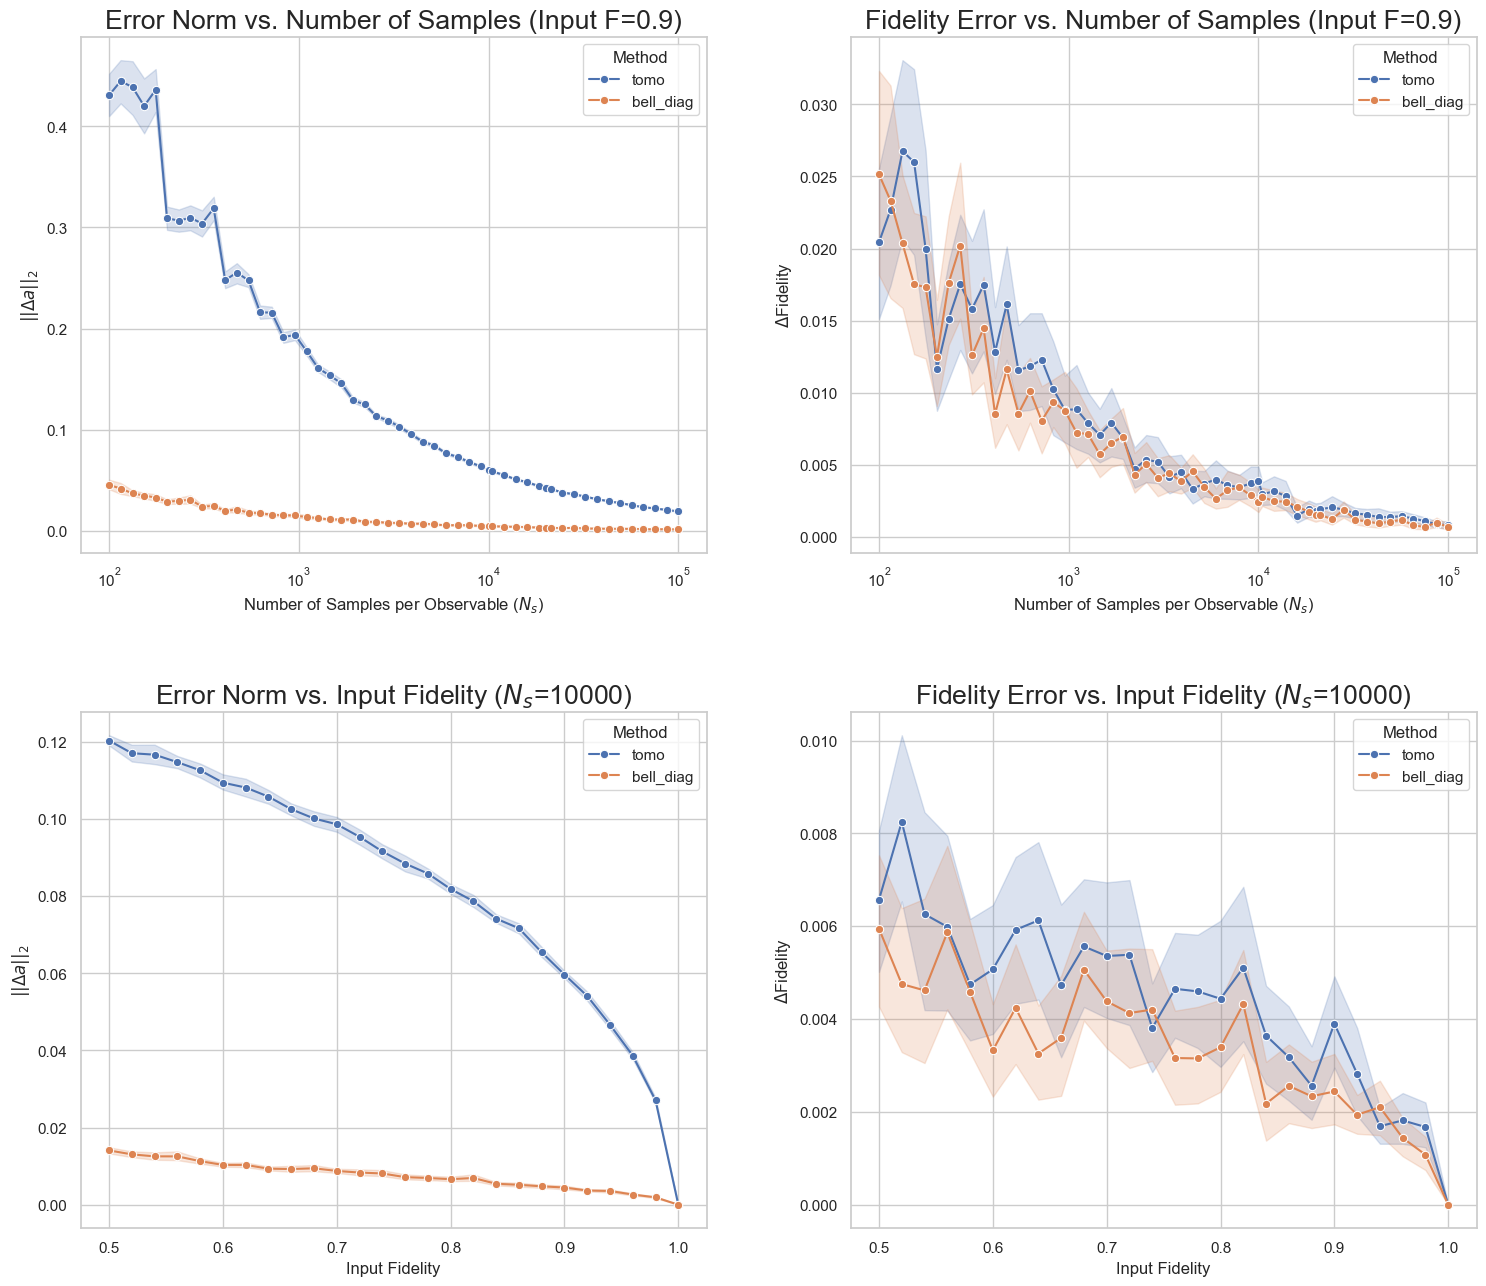

In [5]:
def plot_comparison_results(
    tomo_df: pd.DataFrame,
    bell_diag_df: pd.DataFrame,
    num_qubits: int,
    fixed_fidelity: float,
    fixed_shots: int,
    font_size: int = 16,
    color_palette: str = "colorblind"
    ):
    """
    Generates a 2x2 comparison plot for tomo and bell_diag data.
    """
    sns.set_theme(style="whitegrid", rc={"font.size": font_size, "axes.titlesize": font_size * 1.2})
    
    # Combine the two dataframes for easier plotting with seaborn's 'hue'
    combined_df = pd.concat([tomo_df, bell_diag_df], ignore_index=True)
    
    if combined_df.empty:
        print("No data found for plotting.")
        return

    # filter data
    combined_df = combined_df[combined_df['qubits'] == num_qubits].copy()

    # Filter data for the two main experiment types
    df_exp1 = combined_df[combined_df['input_fidelity'] == fixed_fidelity].copy()
    df_exp2 = combined_df[combined_df['total_shots'] == fixed_shots].copy()

    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # --- Row 1: Varying Shots ---
    ax1, ax2 = axes[0, 0], axes[0, 1]
    
    sns.lineplot(data=df_exp1, x="total_shots", y="delta_a_norm_2", hue="prefix", ax=ax1, marker='o')
    ax1.set_title(f"Error Norm vs. Number of Samples (Input F={fixed_fidelity})")
    ax1.set_xlabel("Number of Samples per Observable ($N_s$)")
    ax1.set_ylabel(r"$||\Delta a||_2$")
    ax1.set_xscale("log")

    sns.lineplot(data=df_exp1, x="total_shots", y="delta_fidelity", hue="prefix", ax=ax2, marker='o')
    ax2.set_title(f"Fidelity Error vs. Number of Samples (Input F={fixed_fidelity})")
    ax2.set_xlabel("Number of Samples per Observable ($N_s$)")
    ax2.set_ylabel(r"$\Delta$Fidelity")
    ax2.set_xscale("log")

    # --- Row 2: Varying Input Fidelity ---
    ax3, ax4 = axes[1, 0], axes[1, 1]
    
    sns.lineplot(data=df_exp2, x="input_fidelity", y="delta_a_norm_2", hue="prefix", ax=ax3, marker='o')
    ax3.set_title(f"Error Norm vs. Input Fidelity ($N_s$={fixed_shots})")
    ax3.set_xlabel("Input Fidelity")
    ax3.set_ylabel(r"$||\Delta a||_2$")

    sns.lineplot(data=df_exp2, x="input_fidelity", y="delta_fidelity", hue="prefix", ax=ax4, marker='o')
    ax4.set_title(f"Fidelity Error vs. Input Fidelity ($N_s$={fixed_shots})")
    ax4.set_xlabel("Input Fidelity")
    ax4.set_ylabel(r"$\Delta$Fidelity")

    # Improve legends
    for ax in axes.flatten():
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles, labels=labels, title="Method")

    plt.tight_layout(pad=3.0)
    plot_filename = os.path.join("plots", f"comparison_plot_{num_qubits}q.png")
    plt.savefig(plot_filename, dpi=300)
    print(f"\nSaved comparison plot to: {plot_filename}")



tomo_df = load_data_for_plotting('tomo_data', 'tomo')
bell_diag_df = load_data_for_plotting('bell_diag_data', 'bell_diag')
plot_comparison_results(tomo_df, bell_diag_df, 8, 0.9, 10_000)


Saved comparison plot to: plots/comparison_plot_8q.png


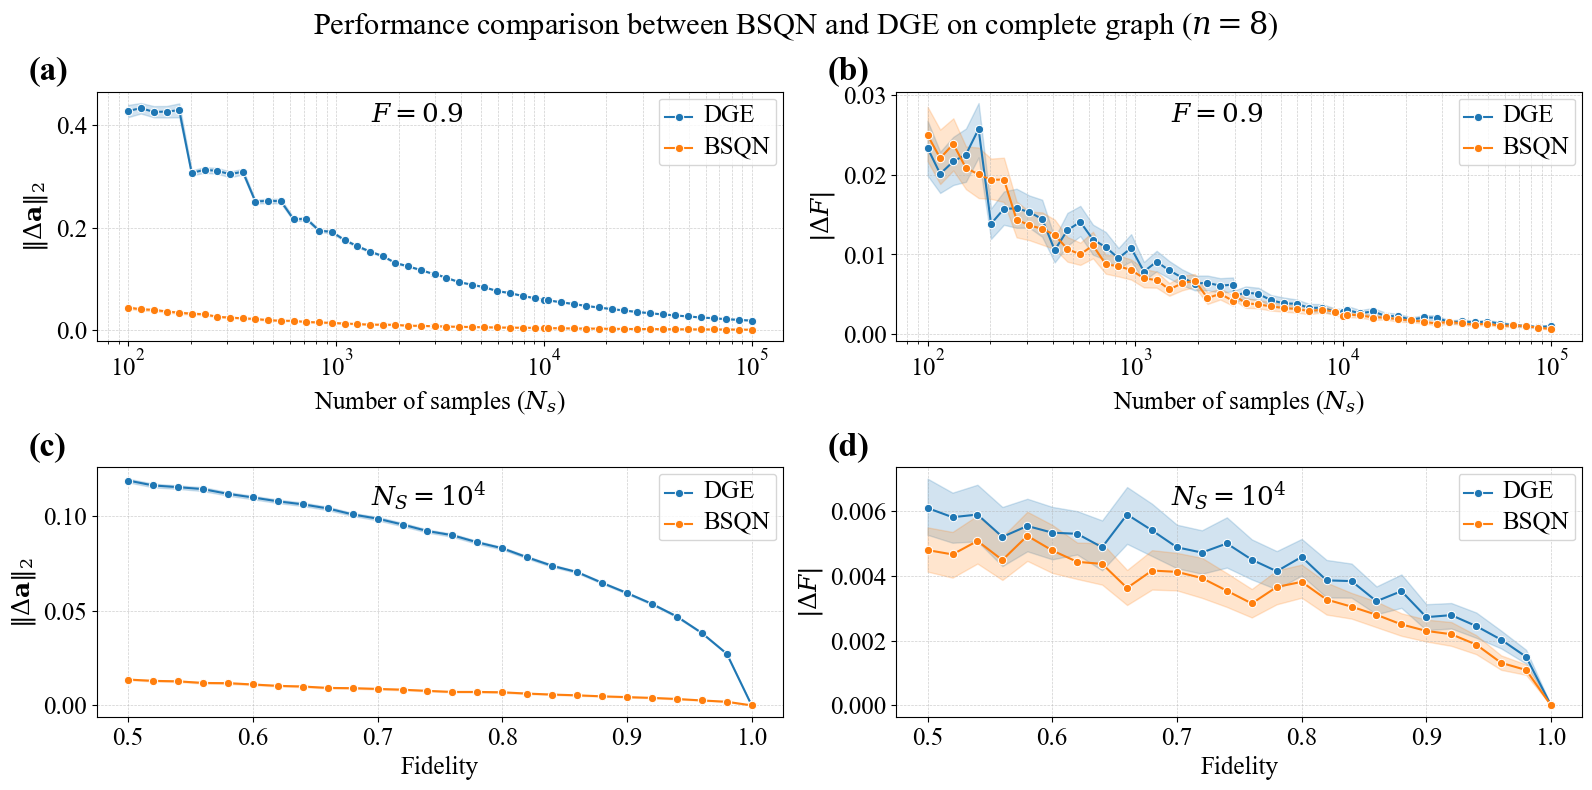

In [13]:
def plot_comparison_results(
    tomo_df: pd.DataFrame,
    bell_diag_df: pd.DataFrame,
    num_qubits: int,
    fixed_fidelity: float,
    fixed_shots: int,
    title_fontsize: int = 19,
    label_fontsize: int = 18,
    legend_fontsize: int = 18,
    tick_fontsize: int = 18,
    legend_mapping: dict = None
    ):
    """
    Generates a 2x2 comparison plot with customizable fonts and legends.
    """
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    
    # Combine the two dataframes for easier plotting with seaborn's 'hue'
    combined_df = pd.concat([tomo_df, bell_diag_df], ignore_index=True)
    
    if combined_df.empty:
        print("No data found for plotting.")
        return

    # If a mapping is provided, rename the prefixes for a cleaner legend.
    # Otherwise, use the original prefixes.
    if legend_mapping:
        combined_df['prefix'] = combined_df['prefix'].map(legend_mapping)

    # Filter data for the specified number of qubits
    combined_df = combined_df[combined_df['qubits'] == num_qubits].copy()

    # Filter data for the two main experiment types
    df_exp1 = combined_df[combined_df['input_fidelity'] == fixed_fidelity].copy()
    df_exp1 = df_exp1[df_exp1['total_shots'] <= 10**5].copy()
    # df_exp1 = df_exp1[df_exp1['total_shots'] >= 10**3].copy()

    df_exp2 = combined_df[combined_df['total_shots'] == fixed_shots].copy()

    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    fig.suptitle(f'Performance comparison between BSQN and DGE on complete graph ($n = {num_qubits}$)', fontsize=22)

    # Add labels (a), (b), (c), (d) to the subplots
    subplot_labels = ['(a)', '(b)', '(c)', '(d)']
    label_font_props = {'fontsize': title_fontsize * 1.3, 'fontweight': 'bold', 'fontfamily': 'Times New Roman'}
    for i, ax in enumerate(axes.flatten()):
        ax.text(-0.1, 1.05, subplot_labels[i], transform=ax.transAxes, **label_font_props)

    # --- Row 1: Varying Shots ---
    ax1, ax2 = axes[0, 0], axes[0, 1]
    
    sns.lineplot(data=df_exp1, x="total_shots", y="delta_a_norm_2", hue="prefix", ax=ax1, marker='o')
    # ax1.set_title(f"Error Norm vs. Number of Samples (Input F={fixed_fidelity})", fontsize=title_fontsize)
    ax1.text(0.4, 0.95, f"$F = {fixed_fidelity}$",
             transform=ax1.transAxes, fontsize=title_fontsize, verticalalignment='top')
    ax1.set_xlabel("Number of samples ($N_s$)", fontsize=label_fontsize)
    ax1.set_ylabel(r"$\Vert\Delta \mathbf{a}\Vert_2$", fontsize=label_fontsize)
    ax1.set_xscale("log")

    sns.lineplot(data=df_exp1, x="total_shots", y="delta_fidelity", hue="prefix", ax=ax2, marker='o')
    # ax2.set_title(f"Fidelity Error vs. Number of Samples (Input F={fixed_fidelity})", fontsize=title_fontsize)
    ax2.text(0.4, 0.95, f"$F = {fixed_fidelity}$",
             transform=ax2.transAxes, fontsize=title_fontsize, verticalalignment='top')
    ax2.set_xlabel("Number of samples ($N_s$)", fontsize=label_fontsize)
    ax2.set_ylabel(r"$\vert\Delta F\vert$", fontsize=label_fontsize)
    ax2.set_xscale("log")

    # --- Row 2: Varying Input Fidelity ---
    ax3, ax4 = axes[1, 0], axes[1, 1]
    
    sns.lineplot(data=df_exp2, x="input_fidelity", y="delta_a_norm_2", hue="prefix", ax=ax3, marker='o')
    # ax3.set_title(f"2-Norm vs. Fidelity (Shots={fixed_shots})", fontsize=title_fontsize)
    ax3.text(0.4, 0.95, f"$N_S = 10^4$",
             transform=ax3.transAxes, fontsize=title_fontsize, verticalalignment='top')
    ax3.set_xlabel("Fidelity", fontsize=label_fontsize)
    ax3.set_ylabel(r"$\Vert\Delta \mathbf{a}\Vert_2$", fontsize=label_fontsize)

    sns.lineplot(data=df_exp2, x="input_fidelity", y="delta_fidelity", hue="prefix", ax=ax4, marker='o')
    # ax4.set_title(f"Estimated Fidelity vs. Input Fidelity (Shots={fixed_shots})", fontsize=title_fontsize)
    ax4.text(0.4, 0.95, f"$N_S = 10^{{{int(np.log10(fixed_shots))}}}$",
             transform=ax4.transAxes, fontsize=title_fontsize, verticalalignment='top')
    ax4.set_xlabel("Fidelity", fontsize=label_fontsize)
    ax4.set_ylabel(r"$\vert\Delta F\vert$", fontsize=label_fontsize)

    for ax in axes.flatten():
        # Set tick font size
        ax.tick_params(axis='x', labelsize=tick_fontsize)
        ax.tick_params(axis='y', labelsize=tick_fontsize)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)

        # Customize legend
        legend = ax.get_legend()
        if legend:
            legend.set_title(None) # This line removes the legend title
            plt.setp(legend.get_texts(), fontsize=legend_fontsize)

    plt.tight_layout(pad=1)
    
    # Ensure plots directory exists
    os.makedirs("plots", exist_ok=True)
    plot_filename = os.path.join("plots", f"comparison_plot_{num_qubits}q.pdf")
    plot_filename = os.path.join("plots", f"comparison_plot_{num_qubits}q.png")
    plt.savefig(plot_filename, dpi=300)
    print(f"\nSaved comparison plot to: {plot_filename}")

# tomo_df = load_data_for_plotting('tomo_data', 'tomo')
# bell_diag_df = load_data_for_plotting('bell_diag_data', 'bell_diag')
# plot_comparison_results(tomo_df, bell_diag_df, 8, 0.9, 10_000, legend_mapping={
#     'tomo': 'DGE',
#     'bell_diag': 'BSQN',
# })

tomo_df = load_data_for_plotting('more_tomo_data', 'tomo')
bell_diag_df = load_data_for_plotting('more_bell_diag_data', 'bell_diag')
plot_comparison_results(tomo_df, bell_diag_df, 8, 0.9, 10_000, legend_mapping={
    'tomo': 'DGE',
    'bell_diag': 'BSQN',
})

In [ ]:
def load_all_fidelity_data(output_dir: str):
    """
    Loads all 'bell_fidelity' data, calculates metrics, and returns a DataFrame.
    """
    all_data = []
    file_pattern = re.compile(
        r"bell_fidelity_(\d+)q_F([\d.]+)_err_(.*?)_shots_(\d+)_numstab_(\d+).npy"
    )
    
    if not os.path.isdir(output_dir):
        print(f"Warning: Fidelity data directory '{output_dir}' not found. Returning empty DataFrame.")
        return pd.DataFrame()

    for filename in os.listdir(output_dir):
        match = file_pattern.match(filename)
        if match:
            qubits, F_str, err, shots, numstab = match.groups()
            qubits = int(qubits)
            input_F = float(F_str)
            shots = int(shots)
            numstab = int(numstab)
            
            filepath = os.path.join(output_dir, filename)
            fidelities_array = np.load(filepath)
            
            for i, est_fidelity in enumerate(fidelities_array):
                all_data.append({
                    "qubits": qubits,
                    "input_fidelity": input_F,
                    "error_model": err,
                    "shots": shots,
                    "numstab": numstab,
                    "repeat": i,
                    "estimated_fidelity": est_fidelity,
                    "fidelity_error": np.abs(est_fidelity - input_F) # (est - true)
                })
    return pd.DataFrame(all_data)

<>:75: SyntaxWarning: invalid escape sequence '\m'
<>:75: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2j/j63y2mx97lqg43npqy6xqc500000gn/T/ipykernel_79000/2976503397.py:75: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title('Complete graph (F = 0.9) under depolarizing noise $(\mathcal{N}_1)$', fontsize=22)



Saved comparison plot to: plots/comparison_plot_varying_size_F0.9.pdf


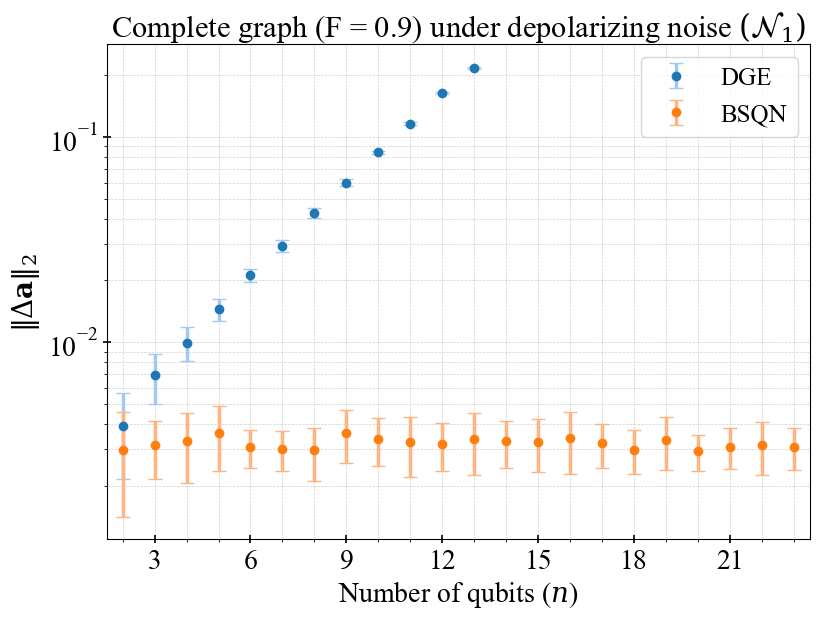

In [30]:
def plot_diag_est_varying_size(
    tomo_df: pd.DataFrame,
    bell_diag_df: pd.DataFrame,
    fixed_fidelity: float,
    fixed_shots: int,
    title_fontsize: int = 19,
    label_fontsize: int = 20,
    legend_fontsize: int = 20,
    tick_fontsize: int = 20,
    legend_mapping: dict = None,
    error_bar: Union[str, tuple] = 'sd',
    err_style: str = 'bars',
    ):

    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    color_list = sns.color_palette("Paired")
    blue = sns.color_palette("Blues", 14)
    yellow = sns.color_palette("YlOrBr", 14)
    palette = sns.color_palette()

    # Apply the specific data cuts for each dataframe
    tomo_df_filtered = tomo_df[tomo_df['qubits'] <= 13]
    bell_diag_df_filtered = bell_diag_df[bell_diag_df['qubits'] <= 30]

    # Combine the two dataframes for easier plotting with seaborn's 'hue'
    combined_df = pd.concat([tomo_df_filtered, bell_diag_df_filtered], ignore_index=True)
    
    if combined_df.empty:
        print("No data found for plotting.")
        return

    # If a mapping is provided, rename the prefixes for a cleaner legend.
    if legend_mapping:
        combined_df['prefix'] = combined_df['prefix'].map(legend_mapping)

    # Filter data for the fixed experimental parameters
    df_exp = combined_df[combined_df['input_fidelity'] == fixed_fidelity].copy()
    df_exp = df_exp[df_exp['total_shots'] == fixed_shots].copy()

    # fig, ax = plt.subplots(figsize=(8, 6))
    fig, ax = plt.subplots(figsize=(8, 6))
    # palette = sns.color_palette("colorblind", n_colors=len(df_exp['prefix'].unique()))
    color_map = {prefix: color for prefix, color in zip(reversed(sorted(df_exp['prefix'].unique())), palette)}
    efactor = 0.8
    e_color_map = {prefix: (efactor * color[0], efactor * color[1], efactor * color[2]) for prefix, color in zip(reversed(sorted(df_exp['prefix'].unique())), palette)}
    e_color_map = {prefix: color for prefix, color in zip(reversed(sorted(df_exp['prefix'].unique())), sns.color_palette('pastel'))}

    
    # Plot the main data with specified error bar style
    # sns.lineplot(data=df_exp, x="qubits", y="delta_a_norm_2", linestyle='', hue="prefix", ax=ax, marker='o', errorbar=error_bar, err_style=err_style)
    for prefix, color in color_map.items():
        subset = df_exp[df_exp['prefix'] == prefix]
        if not subset.empty:
            grouped = subset.groupby('qubits')['delta_a_norm_2']
            mean_vals = grouped.mean()
            std_vals = grouped.std()
            # print(f'label = {prefix}')
            ax.errorbar(mean_vals.index, mean_vals.values, yerr=std_vals.values,
                        marker='o', capsize=5, color=color, ecolor=e_color_map[prefix], label=prefix, linestyle='', elinewidth=2.5)
    
    ax.set_xlabel("Number of qubits ($n$)", fontsize=label_fontsize)
    ax.set_ylabel(r"$\Vert\Delta \mathbf{a}\Vert_2$", fontsize=label_fontsize)
    
    # Ensure x-axis ticks are integers
    min_q = df_exp['qubits'].min()
    max_q = df_exp['qubits'].max()
    ax.set_xlim(min_q - 0.5, max_q + 0.5)

    # Customize ticks and legend
    ax.tick_params(axis='x', labelsize=tick_fontsize)
    ax.tick_params(axis='y', labelsize=tick_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize, direction='inout', length=6, width=1.2)
    # sns.set_style('ticks')  # white style with tick marks
    ax.set_title('Complete graph (F = 0.9) under depolarizing noise $(\mathcal{N}_1)$', fontsize=22)
    # ax.text(0.4, 0.95, f"$N_S = 10^4$",
            #  transform=ax.transAxes, fontsize=title_fontsize, verticalalignment='top')
    ax.set_yscale('log')
    
    # ax.xaxis.set_major_locator(MaxNLocator(integer=True, min_n_ticks=1))
    ax.xaxis.set_major_locator(MultipleLocator(3))
    ax.xaxis.set_minor_locator(MultipleLocator(1))

    ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5, alpha=0.6)
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, alpha=0.6) # Major and minor for y log scale

    legend = ax.get_legend()
    if legend:
        # sns.move_legend(ax, "center right")
        legend.set_title(None)
        plt.setp(legend.get_texts(), fontsize=legend_fontsize)

    
    ax.legend()
    # plt.tight_layout(pad=1.0)
    plt.tight_layout(pad=0)
    
    # Ensure plots directory exists
    os.makedirs("plots", exist_ok=True)
    plot_filename = os.path.join("plots", f"comparison_plot_varying_size_F{fixed_fidelity}.pdf")
    plt.savefig(plot_filename, dpi=300)
    print(f"\nSaved comparison plot to: {plot_filename}")

tomo_df = load_data_for_plotting('tomo_data', 'tomo')
bell_diag_df = load_data_for_plotting('bell_diag_data', 'bell_diag')
plot_diag_est_varying_size(tomo_df, bell_diag_df, 0.9, 20_000, legend_mapping={
# plot_diag_est_varying_size(tomo_df, bell_diag_df, 0.9, 5000, legend_mapping={
    'tomo': 'DGE',
    'bell_diag': 'BSQN',
})


Saved plot to: plots/fidelity_vs_qubits.pdf


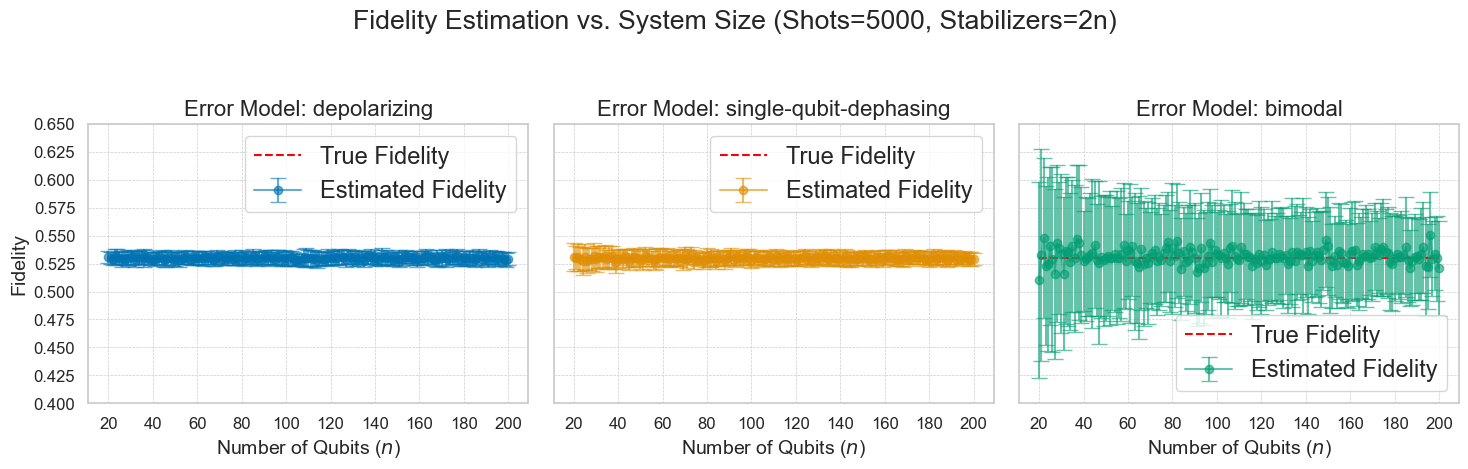

In [28]:
def plot_fidelity_vs_qubits(
    fidelity_df: pd.DataFrame,
    fixed_shots: int,
    error_models: List[str],
    font_family: str = 'sans-serif',
    mathtext_fontset: str = 'dejavusans',
    label_fontsize: int = 14,
    title_fontsize: int = 16,
    tick_fontsize: int = 12,
    capsize: int = 6 # Changed default capsize to 6
    ):
    """
    Plots fidelity vs. number of qubits for different error models.
    (Plot 1)
    """
    plt.rcParams['font.family'] = font_family
    plt.rcParams['mathtext.fontset'] = mathtext_fontset
    
    num_err_models = len(error_models)
    fig, axes = plt.subplots(1, num_err_models, figsize=(5 * num_err_models, 5), sharey=True)
    if num_err_models == 1:
        axes = [axes] # Make it iterable if only one
    
    # Use a color palette for the different subplots
    palette = sns.color_palette("colorblind", num_err_models)
        
    for ax, err_model, color in zip(axes, error_models, palette):
        # Filter for this subplot: 2n stabilizers and specific error model
        df_plot = fidelity_df[
            (fidelity_df['error_model'] == err_model) &
            (fidelity_df['shots'] == fixed_shots) &
            (fidelity_df['numstab'] == fidelity_df['qubits'] * 2)
        ].copy()
        
        if df_plot.empty:
            ax.set_title(f"{err_model}\n(No data)", fontsize=title_fontsize)
            continue
            
        # Group by qubits to get mean/std of estimated fidelity
        grouped = df_plot.groupby('qubits')['estimated_fidelity']
        mean_fid = grouped.mean()
        std_fid = grouped.std()
        
        # Plot mean fidelity with error bars
        ax.errorbar(mean_fid.index, mean_fid.values, yerr=std_fid.values,
                    marker='o', capsize=capsize, color=color,
                    ecolor=color, elinewidth=1.5, alpha=0.6, # Use color, make transparent
                    label="Estimated Fidelity")
        
        # Plot the true fidelity (input_fidelity) as a reference line
        true_fid_line = df_plot.groupby('qubits')['input_fidelity'].mean()
        ax.plot(true_fid_line.index, true_fid_line.values, linestyle='--', color='red', label="True Fidelity")
        
        ax.set_title(f"Error Model: {err_model}", fontsize=title_fontsize)
        ax.set_xlabel("Number of Qubits ($n$)", fontsize=label_fontsize)
        
        # Set x-ticks in steps of 2 (assuming 20 was a typo)
        if not mean_fid.empty:
            min_q = mean_fid.index.min()
            max_q = mean_fid.index.max()
            ax.set_xticks(np.arange(min_q, max_q + 1, 20))
        
        ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
        ax.legend()
        
        # Add grid and set y-ticks
        ax.grid(True, which='major', linestyle='--', linewidth=0.5)
        if not mean_fid.empty:
            y_min = (mean_fid - std_fid).min()
            y_max = (mean_fid + std_fid).max()
            if not true_fid_line.empty:
                y_min = min(y_min, true_fid_line.min())
                y_max = max(y_max, true_fid_line.max())
            
            # Set y-ticks in steps of 0.025
            y_min_rounded = np.floor(y_min / 0.025) * 0.025
            y_max_rounded = np.ceil(y_max / 0.025) * 0.025
            ax.set_yticks(np.arange(y_min_rounded, y_max_rounded + 0.025, 0.025))


    axes[0].set_ylabel("Fidelity", fontsize=label_fontsize)
    fig.suptitle(f"Fidelity Estimation vs. System Size (Shots={fixed_shots}, Stabilizers=2n)", fontsize=title_fontsize * 1.2)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    os.makedirs("plots", exist_ok=True)
    plot_filename = os.path.join("plots", "fidelity_vs_qubits.pdf")
    plt.savefig(plot_filename, dpi=300)
    print(f"\nSaved plot to: {plot_filename}")

df = load_all_fidelity_data('bell_fidelity_data')
plot_fidelity_vs_qubits(df, 5000, ['depolarizing', 'single-qubit-dephasing', 'bimodal'])

<>:129: SyntaxWarning: invalid escape sequence '\m'
<>:130: SyntaxWarning: invalid escape sequence '\m'
<>:131: SyntaxWarning: invalid escape sequence '\m'
<>:129: SyntaxWarning: invalid escape sequence '\m'
<>:130: SyntaxWarning: invalid escape sequence '\m'
<>:131: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2j/j63y2mx97lqg43npqy6xqc500000gn/T/ipykernel_33591/1552729437.py:129: SyntaxWarning: invalid escape sequence '\m'
  'depolarizing': 'Depolarizing $(\mathcal{N}_1)$',
/var/folders/2j/j63y2mx97lqg43npqy6xqc500000gn/T/ipykernel_33591/1552729437.py:130: SyntaxWarning: invalid escape sequence '\m'
  'single-qubit-dephasing': 'Single-qubit dephasing $(\mathcal{N}_2)$',
/var/folders/2j/j63y2mx97lqg43npqy6xqc500000gn/T/ipykernel_33591/1552729437.py:131: SyntaxWarning: invalid escape sequence '\m'
  'bimodal': 'Bimodal $(\mathcal{N}_3)$'



Saved plot to: plots/fidelity_vs_qubits_shaded.pdf


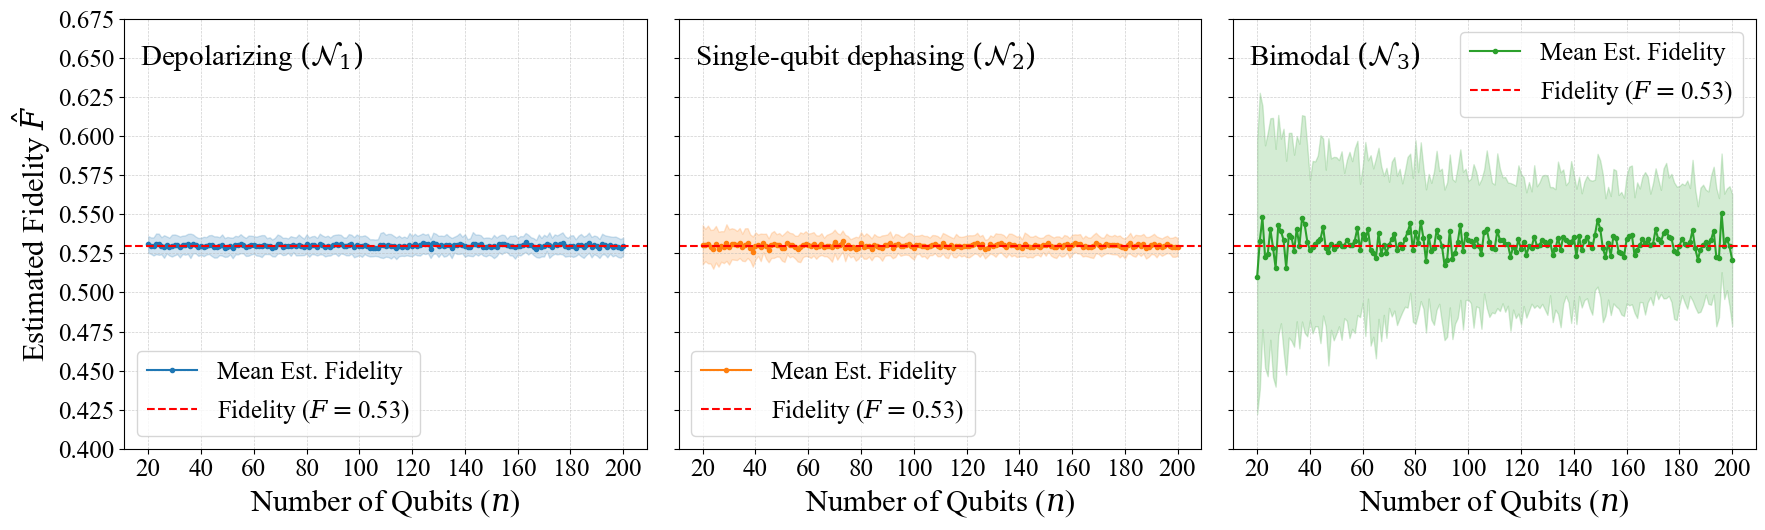

In [33]:
def plot_fidelity_vs_qubits(
    fidelity_df: pd.DataFrame,
    fixed_shots: int,
    error_models: List[str],
    font_family: str = 'Times New Roman',
    mathtext_fontset: str = 'dejavuserif',
    capsize: int = 6, # Changed default capsize to 6
    legend_mapping: dict = None # Added legend_mapping
    ):
    """
    Plots fidelity vs. number of qubits for different error models,
    using shaded error regions and global font settings.
    (Plot 1, revised style)
    """
    # --- Set global font sizes using rcParams ---
    label_fontsize = 22
    title_fontsize = 21
    tick_fontsize = 18
    legend_fontsize = 18
    plt.rcParams['font.size'] = 18          # Default font size
    plt.rcParams['axes.labelsize'] = label_fontsize
    plt.rcParams['axes.titlesize'] = title_fontsize
    plt.rcParams['xtick.labelsize'] = tick_fontsize
    plt.rcParams['ytick.labelsize'] = tick_fontsize
    plt.rcParams['legend.fontsize'] = legend_fontsize
    plt.rcParams['font.family'] = font_family
    plt.rcParams['mathtext.fontset'] = mathtext_fontset
    
    num_err_models = len(error_models)
    fig, axes = plt.subplots(1, num_err_models, figsize=(6 * num_err_models, 6), sharey=True) # Adjusted figsize
    if num_err_models == 1:
        axes = [axes] # Make it iterable if only one
    
    # Define colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Use the example colors
    if len(colors) < num_err_models:
        # Fallback to a palette if not enough defined colors
        colors = sns.color_palette("colorblind", num_err_models)
        
    for ax, err_model, color in zip(axes, error_models, colors):
        # Filter for this subplot: 2n stabilizers and specific error model
        df_plot = fidelity_df[
            (fidelity_df['error_model'] == err_model) &
            (fidelity_df['shots'] == fixed_shots) &
            (fidelity_df['numstab'] == fidelity_df['qubits'] * 2)
        ].copy()
        
        if df_plot.empty:
            ax.text(0.5, 0.5, "(No data)", transform=ax.transAxes,
                    ha='center', va='center', fontsize=title_fontsize)
            # Use mapped title if available, otherwise use original
            display_title = legend_mapping.get(err_model, err_model.replace('-', ' ').title()) if legend_mapping else err_model.replace('-', ' ').title()
            ax.set_title(display_title, fontsize=title_fontsize) # Keep title for context
            continue
            
        # Group by qubits to get mean/std of estimated fidelity
        grouped = df_plot.groupby('qubits')['estimated_fidelity']
        mean_fid = grouped.mean()
        std_fid = grouped.std()
        
        # --- Plotting using ax.plot and ax.fill_between ---
        x_values = mean_fid.index
        y_means = mean_fid.values
        y_stds = std_fid.values

        # Plot the mean estimated fidelity line
        ax.plot(x_values, y_means, 'o-', color=color, markersize=3, label='Mean Est. Fidelity')
        
        # Plot the shaded envelope (1 standard deviation)
        ax.fill_between(x_values, y_means - y_stds, y_means + y_stds, 
                        color=color, alpha=0.2, 
                        # label='Std Dev Envelope' # Usually label only the mean line
                        )
        
        # Plot the true fidelity (input_fidelity) as a reference line
        # Assuming true fidelity is constant for this plot
        true_fidelity_val = df_plot['input_fidelity'].iloc[0]
        ax.axhline(y=true_fidelity_val, color='r', linestyle='--', linewidth=1.5, label=f'Fidelity ($F =${true_fidelity_val:.2f})') # Formatted true fidelity

        # Put title inside the plot, using mapped name if available
        display_title = legend_mapping.get(err_model, err_model.replace('_', ' ').title()) if legend_mapping else err_model.replace('_', ' ').title()
        # Adjust position based on title length slightly
        x_pos = 0.05 if len(display_title) <= 14 else 0.03
        ax.text(x_pos, 0.95, display_title, transform=ax.transAxes,
                fontsize=title_fontsize, verticalalignment='top',
                # fontweight='bold' # Optional: make title bold
                )

        ax.set_xlabel("Number of Qubits ($n$)")
        
        # Set x-ticks in steps of 20 (as requested in prompt, adjust if needed)
        if not mean_fid.empty:
            min_q = x_values.min()
            max_q = x_values.max()
            # Ensure ticks start near min_q and go up to max_q
            start_tick = np.ceil(min_q / 20.0) * 20
            ax.set_xticks(np.arange(start_tick, max_q + 1, 20))
        
        ax.legend()
        
        # Add grid and set y-ticks
        ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.6)
        if not mean_fid.empty:
            y_min = (y_means - y_stds).min()
            y_max = (y_means + y_stds).max()
            y_min = min(y_min, true_fidelity_val)
            y_max = max(y_max, true_fidelity_val)
            
            # Set y-ticks in steps of 0.025
            y_min_rounded = np.floor(y_min / 0.025) * 0.025
            y_max_rounded = np.ceil(y_max / 0.025) * 0.025
            # Add small buffer to avoid clipping envelope
            ax.set_yticks(np.arange(y_min_rounded, y_max_rounded + 0.035, 0.025))


    axes[0].set_ylabel(r"Estimated Fidelity $\hat{F}$")
    # No suptitle needed as titles are inside plots now
    # fig.suptitle(f"Fidelity Estimation vs. System Size (Shots={fixed_shots}, Stabilizers=2n)", fontsize=plt.rcParams['figure.titlesize'])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust rect slightly if needed
    
    os.makedirs("plots", exist_ok=True)
    plot_filename = os.path.join("plots", "fidelity_vs_qubits_shaded.pdf") # Changed filename
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"\nSaved plot to: {plot_filename}")

df = load_all_fidelity_data('bell_fidelity_data')
plot_fidelity_vs_qubits(df, 5000, ['depolarizing', 'single-qubit-dephasing', 'bimodal'], legend_mapping={
    'depolarizing': 'Depolarizing $(\mathcal{N}_1)$', 
    'single-qubit-dephasing': 'Single-qubit dephasing $(\mathcal{N}_2)$', 
    'bimodal': 'Bimodal $(\mathcal{N}_3)$'
})

<>:142: SyntaxWarning: invalid escape sequence '\m'
<>:143: SyntaxWarning: invalid escape sequence '\m'
<>:144: SyntaxWarning: invalid escape sequence '\m'
<>:142: SyntaxWarning: invalid escape sequence '\m'
<>:143: SyntaxWarning: invalid escape sequence '\m'
<>:144: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2j/j63y2mx97lqg43npqy6xqc500000gn/T/ipykernel_92786/58655334.py:142: SyntaxWarning: invalid escape sequence '\m'
  'depolarizing': 'Depolarizing $(\mathcal{N}_1)$',
/var/folders/2j/j63y2mx97lqg43npqy6xqc500000gn/T/ipykernel_92786/58655334.py:143: SyntaxWarning: invalid escape sequence '\m'
  'single-qubit-dephasing': 'Single qubit dephasing $(\mathcal{N}_2)$',
/var/folders/2j/j63y2mx97lqg43npqy6xqc500000gn/T/ipykernel_92786/58655334.py:144: SyntaxWarning: invalid escape sequence '\m'
  'bimodal': 'Bimodal $(\mathcal{N}_3)$'



Saved plot to: plots/fidelity_std_dev_grid_n40_shaded.pdf


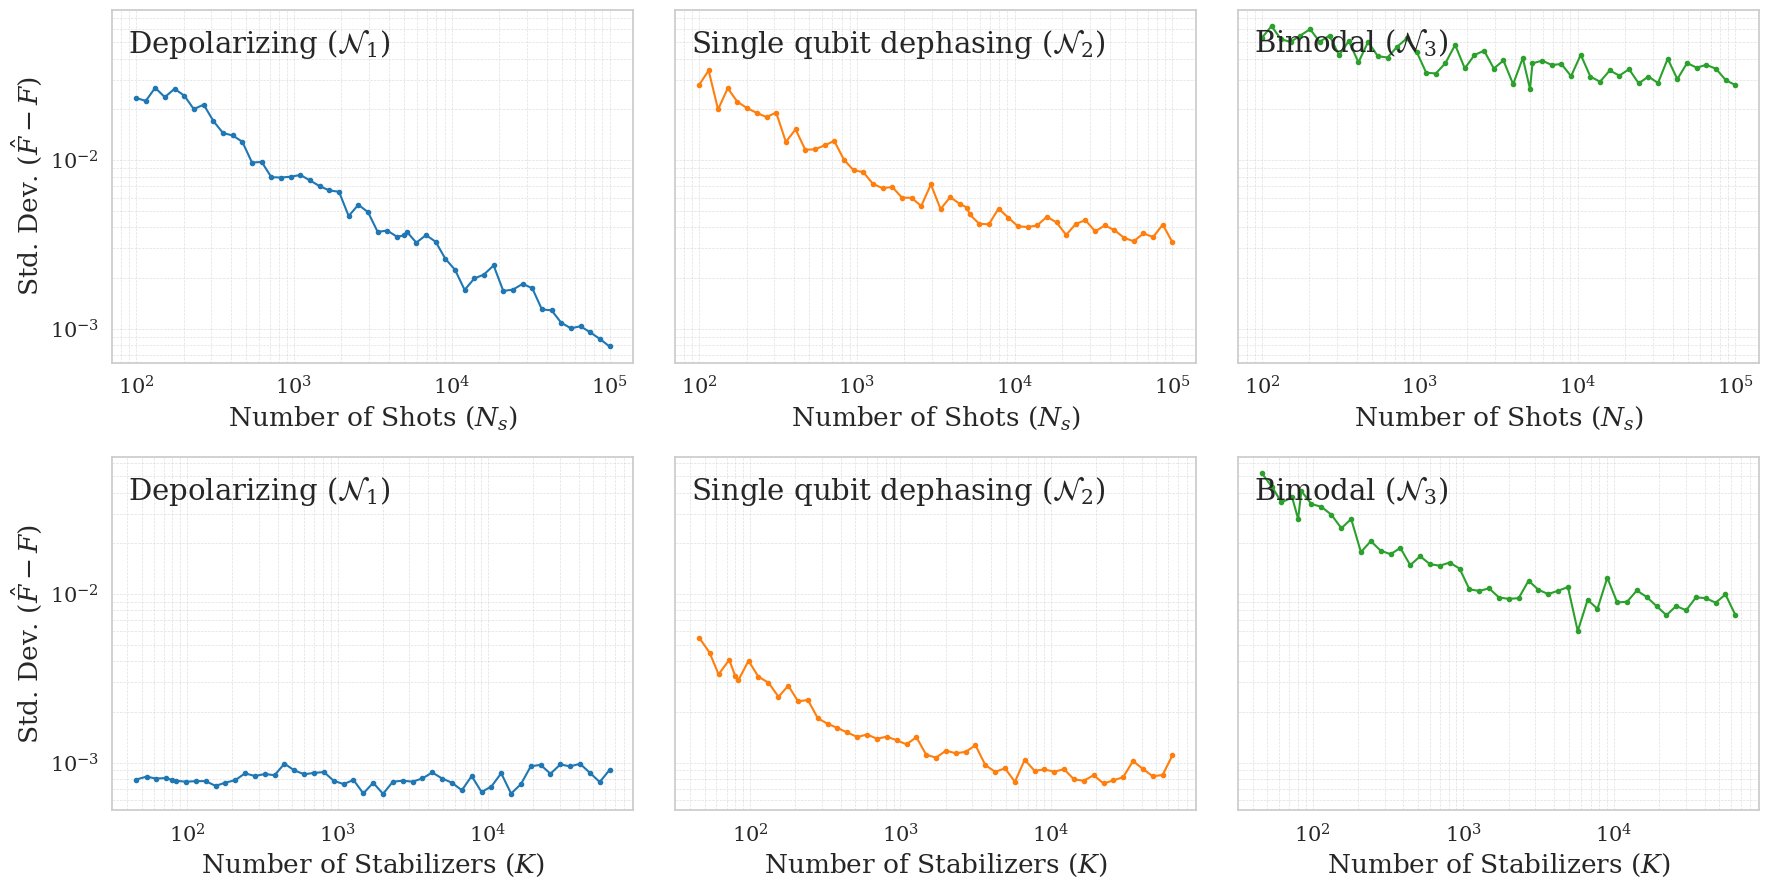

In [27]:
def plot_fidelity_std_dev(
    fidelity_df: pd.DataFrame,
    fixed_shots: int,
    fixed_qubits: int,
    error_models: List[str],
    font_family: str = 'serif',
    mathtext_fontset: str = 'dejavuserif',
    legend_mapping: dict = None # Added legend mapping
    ):
    """
    Plots the standard deviation of fidelity error in a 2x3 grid,
    using shaded error regions and global font settings.
    (Plot 2, revised style)
    """
    # --- Set global font sizes using rcParams ---
    label_fontsize = 19
    title_fontsize = 21
    tick_fontsize = 15
    legend_fontsize = 17
    plt.rcParams['font.size'] = 17          # Default font size
    plt.rcParams['axes.labelsize'] = label_fontsize
    plt.rcParams['axes.titlesize'] = title_fontsize
    plt.rcParams['xtick.labelsize'] = tick_fontsize
    plt.rcParams['ytick.labelsize'] = tick_fontsize
    plt.rcParams['legend.fontsize'] = legend_fontsize
    plt.rcParams['font.family'] = font_family
    plt.rcParams['mathtext.fontset'] = mathtext_fontset
    
    num_err_models = len(error_models)
    fig, axes = plt.subplots(2, num_err_models, figsize=(6 * num_err_models, 10), sharey='row')
    
    # Ensure axes is always a 2D array for consistent indexing
    if num_err_models == 1:
        axes = axes.reshape(2, 1)
    
    # Define colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Use the example colors
    if len(colors) < num_err_models:
        colors = sns.color_palette("colorblind", num_err_models)
        
    # --- Row 1: Varying Shots (Fixed Stabilizers = 2n) ---
    for j, (err_model, color) in enumerate(zip(error_models, colors)):
        ax = axes[0, j]
        df_plot_row1 = fidelity_df[
            (fidelity_df['error_model'] == err_model) &
            (fidelity_df['qubits'] == fixed_qubits) &
            (fidelity_df['numstab'] == fixed_qubits * 2)
        ].copy()
        
        if df_plot_row1.empty:
            display_title = legend_mapping.get(err_model, err_model.replace('_', ' ').title()) if legend_mapping else err_model.replace('_', ' ').title()
            ax.text(0.5, 0.5, "(No data)", transform=ax.transAxes, ha='center', va='center', fontsize=title_fontsize)
            ax.set_title(display_title, fontsize=title_fontsize) # Keep title for context
            continue
            
        # Group by shots, calculate mean and std dev of fidelity_error
        # We need the mean std dev across repeats for the line plot,
        # and the std dev of the std dev for the envelope (approximation)
        grouped_std = df_plot_row1.groupby('shots')['fidelity_error'].std()
        
        # Calculate std dev of the std dev (requires multiple repeats)
        # This is tricky; std dev of std dev isn't standard. Bootstrapping is better.
        # As a placeholder, we'll just plot the mean std dev line.
        x_values_r1 = grouped_std.index
        y_means_r1 = grouped_std.values

        ax.plot(x_values_r1, y_means_r1, 'o-', color=color, markersize=3)
        # ax.fill_between(...) # Shaded error for std dev is complex, omitting for now
        
        # Put title inside plot
        display_title = legend_mapping.get(err_model, err_model.replace('_', ' ').title()) if legend_mapping else err_model.replace('_', ' ').title()
        x_pos = 0.05 if len(display_title) <= 14 else 0.03
        ax.text(x_pos, 0.95, display_title, transform=ax.transAxes,
                fontsize=title_fontsize, verticalalignment='top')

        ax.set_xlabel("Number of Shots ($N_s$)")
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
        
    axes[0, 0].set_ylabel(r"Std. Dev. ($\hat{F} - F$)")
    # fig.text(...) # Row titles are less necessary with titles inside

    # --- Row 2: Varying Stabilizers (Fixed Shots) ---
    for j, (err_model, color) in enumerate(zip(error_models, colors)):
        ax = axes[1, j]
        df_plot_row2 = fidelity_df[
            (fidelity_df['error_model'] == err_model) &
            (fidelity_df['qubits'] == fixed_qubits) &
            (fidelity_df['shots'] == fixed_shots)
        ].copy()
        
        if df_plot_row2.empty:
            display_title = legend_mapping.get(err_model, err_model.replace('_', ' ').title()) if legend_mapping else err_model.replace('_', ' ').title()
            ax.text(0.5, 0.5, "(No data)", transform=ax.transAxes, ha='center', va='center', fontsize=title_fontsize)
            ax.set_title(display_title, fontsize=title_fontsize) # Keep title for context
            continue
            
        # Group by numstab, calculate std dev of fidelity_error
        grouped_std_r2 = df_plot_row2.groupby('numstab')['fidelity_error'].std()
        
        # Filter for range n to n^3
        n = fixed_qubits
        stab_range = [s for s in grouped_std_r2.index if (s >= n and s <= n**3)]
        if not stab_range:
             display_title = legend_mapping.get(err_model, err_model.replace('_', ' ').title()) if legend_mapping else err_model.replace('_', ' ').title()
             ax.text(0.5, 0.5, "(No data in range)", transform=ax.transAxes, ha='center', va='center', fontsize=title_fontsize)
             ax.set_title(display_title, fontsize=title_fontsize) # Keep title for context
             continue
            
        grouped_std_r2 = grouped_std_r2.loc[stab_range]
        x_values_r2 = grouped_std_r2.index
        y_means_r2 = grouped_std_r2.values

        ax.plot(x_values_r2, y_means_r2, 'o-', color=color, markersize=3)
        # ax.fill_between(...) # Shaded error for std dev omitted for now
        
        # Put title inside plot
        display_title = legend_mapping.get(err_model, err_model.replace('_', ' ').title()) if legend_mapping else err_model.replace('_', ' ').title()
        x_pos = 0.05 if len(display_title) <= 14 else 0.03
        ax.text(x_pos, 0.95, display_title, transform=ax.transAxes,
                fontsize=title_fontsize, verticalalignment='top')
        
        ax.set_xlabel("Number of Stabilizers ($K$)")
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)

    axes[1, 0].set_ylabel(r"Std. Dev. ($\hat{F} - F$)")
    # fig.text(...) # Row titles less necessary

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect if needed
    
    os.makedirs("plots", exist_ok=True)
    plot_filename = os.path.join("plots", f"fidelity_std_dev_grid_n{fixed_qubits}_shaded.pdf") # Changed filename
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"\nSaved plot to: {plot_filename}")


df = load_all_fidelity_data('bell_fidelity_data')
plot_fidelity_std_dev(df, 100_000, 40, ['depolarizing', 'single-qubit-dephasing', 'bimodal'], legend_mapping={
    'depolarizing': 'Depolarizing $(\mathcal{N}_1)$', 
    'single-qubit-dephasing': 'Single qubit dephasing $(\mathcal{N}_2)$', 
    'bimodal': 'Bimodal $(\mathcal{N}_3)$'
})

<>:259: SyntaxWarning: invalid escape sequence '\m'
<>:260: SyntaxWarning: invalid escape sequence '\m'
<>:261: SyntaxWarning: invalid escape sequence '\m'
<>:259: SyntaxWarning: invalid escape sequence '\m'
<>:260: SyntaxWarning: invalid escape sequence '\m'
<>:261: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2j/j63y2mx97lqg43npqy6xqc500000gn/T/ipykernel_79000/3009912208.py:259: SyntaxWarning: invalid escape sequence '\m'
  'depolarizing': 'Depolarizing $(\mathcal{N}_1)$',
/var/folders/2j/j63y2mx97lqg43npqy6xqc500000gn/T/ipykernel_79000/3009912208.py:260: SyntaxWarning: invalid escape sequence '\m'
  'single-qubit-dephasing': 'Single qubit dephasing $(\mathcal{N}_2)$',
/var/folders/2j/j63y2mx97lqg43npqy6xqc500000gn/T/ipykernel_79000/3009912208.py:261: SyntaxWarning: invalid escape sequence '\m'
  'bimodal': 'Bimodal $(\mathcal{N}_3)$'



Saved combined std dev plot to: plots/fidelity_std_dev_combined_n40.pdf


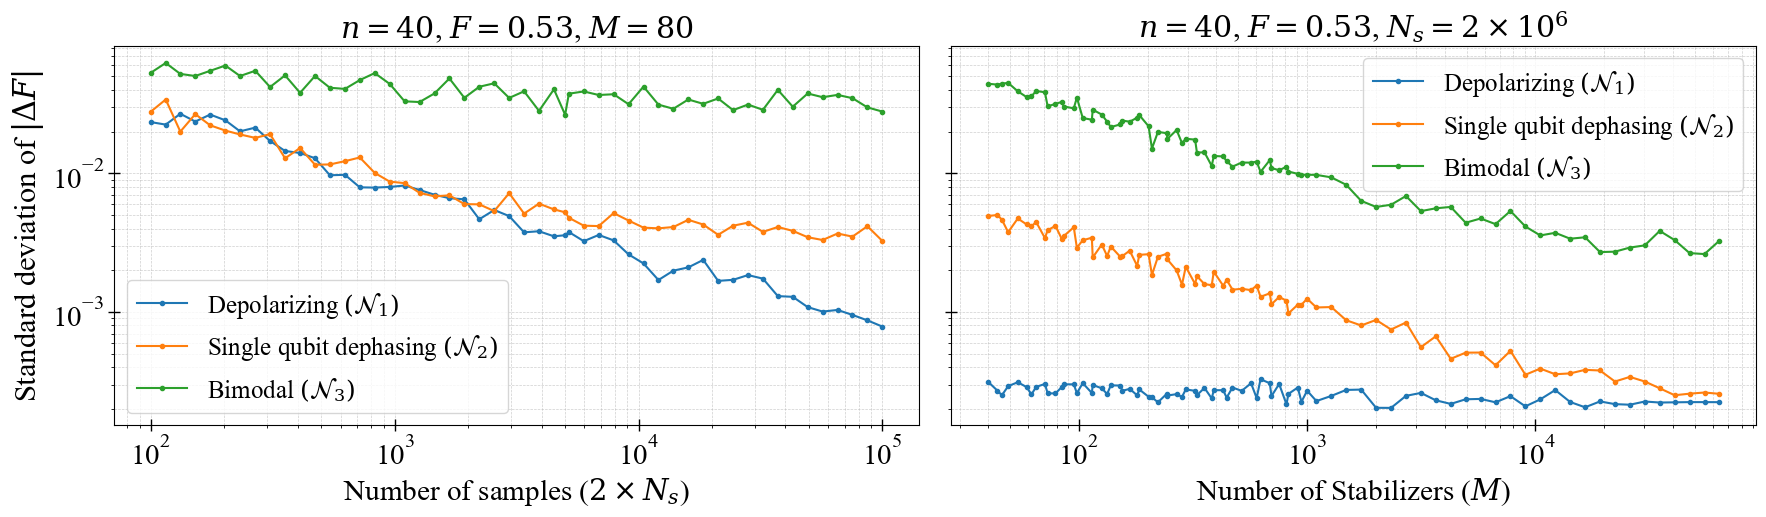

In [13]:
def plot_fidelity_std_dev_combined_new(
    fidelity_df: pd.DataFrame,
    fixed_shots: int,
    fixed_qubits: int,
    error_models: List[str],
    font_family: str = 'Times New Roman',
    mathtext_fontset: str = 'dejavuserif',
    legend_mapping: dict = None # Added legend mapping
    ):
    """
    Plots the standard deviation of fidelity error in a 1x2 grid,
    combining error models onto the same axes.
    (Plot 3, new function)
    """
    # --- Set global font sizes using rcParams ---
    label_fontsize = 19
    title_fontsize = 21
    tick_fontsize = 21 # Increased tick font size as requested in follow-up
    legend_fontsize = 18
    plt.rcParams['font.size'] = 18          # Default font size
    plt.rcParams['axes.labelsize'] = label_fontsize
    # plt.rcParams['axes.titlesize'] = title_fontsize # Titles are now inside plots
    plt.rcParams['xtick.labelsize'] = tick_fontsize
    plt.rcParams['ytick.labelsize'] = tick_fontsize
    plt.rcParams['legend.fontsize'] = legend_fontsize
    plt.rcParams['font.family'] = font_family
    plt.rcParams['mathtext.fontset'] = mathtext_fontset
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True) # 1 row, 2 columns, Increased width slightly
    
    # Define colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Use the example colors
    if len(colors) < len(error_models):
        # Fallback to default cycle if not enough defined colors
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
        
    # --- Left Plot: Varying Shots (Fixed Stabilizers = 2n) ---
    ax_left = axes[0]
    for err_model, color in zip(error_models, colors):
        df_plot_left = fidelity_df[
            (fidelity_df['error_model'] == err_model) &
            (fidelity_df['qubits'] == fixed_qubits) &
            (fidelity_df['numstab'] == fixed_qubits * 2)
        ].copy()
        
        if df_plot_left.empty:
            print(f"No data for {err_model} in left plot.")
            continue
            
        grouped_std_left = df_plot_left.groupby('shots')['fidelity_error'].std()
        x_values_left = grouped_std_left.index
        y_means_left = grouped_std_left.values
        
        label = legend_mapping.get(err_model, err_model.replace('_', ' ').title()) if legend_mapping else err_model.replace('_', ' ').title()
        ax_left.plot(x_values_left, y_means_left, 'o-', color=color, markersize=3, label=label)
        # ax_left.fill_between(...) # Shaded error omitted for simplicity
        
    # ax_left.text(0.05, 0.95, f"Varying Shots (Stabilizers=2n, n={fixed_qubits})",
            #  transform=ax_left.transAxes, fontsize=title_fontsize, verticalalignment='top')
    ax_left.set_title(f"$n = {fixed_qubits}$, $F = 0.53$, $M = {2*fixed_qubits}$") # Updated title
    ax_left.set_xlabel("Number of samples ($N_s$) - Data Value", fontsize=label_fontsize + 2) # Label indicates data value
    ax_left.set_ylabel(r"Standard deviation of $\vert \Delta F\vert$", fontsize=22)
    ax_left.set_xscale("log")
    ax_left.set_yscale("log")
    ax_left.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
    ax_left.legend()
    # Apply tick parameters specifically here
    ax_left.tick_params(axis='both', which='major', direction='inout', length=8, width=1) # Direction inout, increased length

    # --- Custom Tick Formatter for Left X-axis ---
    def format_ticks(x, pos):
        """Formats tick value x into '2 x 10^k'"""
        doubled_x = 2 * x
        if doubled_x <= 0:
            return "" # Avoid log(0) issues
        exponent = int(np.floor(np.log10(doubled_x)))
        # Format as 2x10^k
        return rf'$2 \times 10^{{{exponent}}}$'

    ax_left.xaxis.set_major_formatter(FuncFormatter(format_ticks))

    # --- Right Plot: Varying Stabilizers (Fixed Shots) ---
    ax_right = axes[1]
    for err_model, color in zip(error_models, colors):
        df_plot_right = fidelity_df[
            (fidelity_df['error_model'] == err_model) &
            (fidelity_df['qubits'] == fixed_qubits) &
            (fidelity_df['shots'] == fixed_shots)
        ].copy()
        
        if df_plot_right.empty:
             print(f"No data for {err_model} in right plot.")
             continue
             
        grouped_std_right = df_plot_right.groupby('numstab')['fidelity_error'].std()
        
        n = fixed_qubits
        stab_range = [s for s in grouped_std_right.index if (s >= n and s <= n**3)]
        if not stab_range:
             print(f"No data in range n to n^3 for {err_model} in right plot.")
             continue
            
        grouped_std_right = grouped_std_right.loc[stab_range]
        x_values_right = grouped_std_right.index
        y_means_right = grouped_std_right.values
        
        label = legend_mapping.get(err_model, err_model.replace('_', ' ').title()) if legend_mapping else err_model.replace('_', ' ').title()
        ax_right.plot(x_values_right, y_means_right, 'o-', color=color, markersize=3, 
                      label=label
                      )
        # ax_right.fill_between(...) # Shaded error omitted
        
    # ax_right.text(0.05, 0.95, f"Varying Stabilizers (Shots={fixed_shots}, n={fixed_qubits})",
                #   transform=ax_right.transAxes, fontsize=title_fontsize, verticalalignment='top')
    ax_right.set_title(f"$n = {fixed_qubits}$, $F = 0.53$, $N_s = 10^{int(np.log10(fixed_shots))}$")            
    ax_right.set_xlabel("Number of Stabilizers ($M$)", fontsize=label_fontsize + 2)
    # ax_right.set_ylabel(r"Std. Dev. ($\hat{F} - F$)") # Shared Y axis
    ax_right.set_xscale("log")
    ax_right.set_yscale("log")
    ax_right.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
    ax_right.legend()
    # Apply tick parameters specifically here
    ax_right.tick_params(axis='both', which='major', direction='inout', length=8, width=1) # Direction inout, increased length


    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect if needed
    
    os.makedirs("plots", exist_ok=True)
    plot_filename = os.path.join("plots", f"fidelity_std_dev_combined_n{fixed_qubits}.pdf") # New filename
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"\nSaved combined std dev plot to: {plot_filename}")

def plot_fidelity_std_dev_combined_old(
    fidelity_df: pd.DataFrame,
    fixed_shots: int,
    fixed_qubits: int,
    error_models: List[str],
    font_family: str = 'Times New Roman',
    mathtext_fontset: str = 'dejavuserif',
    legend_mapping: dict = None # Added legend mapping
    ):
    """
    Plots the standard deviation of fidelity error in a 1x2 grid,
    combining error models onto the same axes.
    (Plot 3, new function)
    """
    # --- Set global font sizes using rcParams ---
    label_fontsize = 19
    title_fontsize = 21
    tick_fontsize = 21
    legend_fontsize = 18
    plt.rcParams['font.size'] = 18          # Default font size
    plt.rcParams['axes.labelsize'] = label_fontsize
    # plt.rcParams['axes.titlesize'] = title_fontsize # Titles are now inside plots
    plt.rcParams['xtick.labelsize'] = tick_fontsize
    plt.rcParams['ytick.labelsize'] = tick_fontsize
    plt.rcParams['legend.fontsize'] = legend_fontsize
    plt.rcParams['font.family'] = font_family
    plt.rcParams['mathtext.fontset'] = mathtext_fontset
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True) # 1 row, 2 columns, Increased width slightly
    
    # Define colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Use the example colors
    if len(colors) < len(error_models):
        # Fallback to default cycle if not enough defined colors
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
        
    # --- Left Plot: Varying Shots (Fixed Stabilizers = 2n) ---
    ax_left = axes[0]
    for err_model, color in zip(error_models, colors):
        df_plot_left = fidelity_df[
            (fidelity_df['error_model'] == err_model) &
            (fidelity_df['qubits'] == fixed_qubits) &
            (fidelity_df['numstab'] == fixed_qubits * 2)
        ].copy()
        
        if df_plot_left.empty:
            print(f"No data for {err_model} in left plot.")
            continue
            
        grouped_std_left = df_plot_left.groupby('shots')['fidelity_error'].std()
        x_values_left = grouped_std_left.index
        y_means_left = grouped_std_left.values
        
        label = legend_mapping.get(err_model, err_model.replace('_', ' ').title()) if legend_mapping else err_model.replace('_', ' ').title()
        ax_left.plot(x_values_left, y_means_left, 'o-', color=color, markersize=3, label=label)
        # ax_left.fill_between(...) # Shaded error omitted for simplicity
        
    # ax_left.text(0.05, 0.95, f"Varying Shots (Stabilizers=2n, n={fixed_qubits})",
            #  transform=ax_left.transAxes, fontsize=title_fontsize, verticalalignment='top')
    ax_left.set_title(f"$n = {fixed_qubits}$, $F = 0.53$, $M = {2*fixed_qubits}$") # Updated title
    ax_left.set_xlabel(r"Number of samples ($2 \times N_s$)", fontsize=label_fontsize + 2)
    ax_left.set_ylabel(r"Standard deviation of $\vert \Delta F\vert$", fontsize=22)
    ax_left.set_xscale("log")
    ax_left.set_yscale("log")
    ax_left.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
    ax_left.legend()
    # Apply tick parameters specifically here
    ax_left.tick_params(axis='both', which='major', direction='inout', length=8, width=1) # Direction inout, increased length

    # --- Right Plot: Varying Stabilizers (Fixed Shots) ---
    ax_right = axes[1]
    for err_model, color in zip(error_models, colors):
        df_plot_right = fidelity_df[
            (fidelity_df['error_model'] == err_model) &
            (fidelity_df['qubits'] == fixed_qubits) &
            (fidelity_df['shots'] == fixed_shots)
        ].copy()
        
        if df_plot_right.empty:
             print(f"No data for {err_model} in right plot.")
             continue
             
        grouped_std_right = df_plot_right.groupby('numstab')['fidelity_error'].std()
        
        n = fixed_qubits
        stab_range = [s for s in grouped_std_right.index if (s >= n and s <= n**3)]
        if not stab_range:
             print(f"No data in range n to n^3 for {err_model} in right plot.")
             continue
            
        grouped_std_right = grouped_std_right.loc[stab_range]
        x_values_right = grouped_std_right.index
        y_means_right = grouped_std_right.values
        
        label = legend_mapping.get(err_model, err_model.replace('_', ' ').title()) if legend_mapping else err_model.replace('_', ' ').title()
        ax_right.plot(x_values_right, y_means_right, 'o-', color=color, markersize=3, 
                      label=label
                      )
        # ax_right.fill_between(...) # Shaded error omitted
        
    # ax_right.text(0.05, 0.95, f"Varying Stabilizers (Shots={fixed_shots}, n={fixed_qubits})",
                #   transform=ax_right.transAxes, fontsize=title_fontsize, verticalalignment='top')
    ax_right.set_title(rf"$n = {fixed_qubits}$, $F = 0.53$, $N_s = 2 \times 10^{int(np.log10(fixed_shots))}$")            
    ax_right.set_xlabel("Number of Stabilizers ($M$)", fontsize=label_fontsize + 2)
    # ax_right.set_ylabel(r"Std. Dev. ($\hat{F} - F$)") # Shared Y axis
    ax_right.set_xscale("log")
    ax_right.set_yscale("log")
    ax_right.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
    ax_right.legend()
    # Apply tick parameters specifically here
    ax_right.tick_params(axis='both', which='major', direction='inout', length=8, width=1) # Direction inout, increased length


    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect if needed
    
    os.makedirs("plots", exist_ok=True)
    plot_filename = os.path.join("plots", f"fidelity_std_dev_combined_n{fixed_qubits}.pdf") # New filename
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"\nSaved combined std dev plot to: {plot_filename}")

df = load_all_fidelity_data('bell_fidelity_data')
plot_fidelity_std_dev_combined_old(
# plot_fidelity_std_dev_combined_new(
    df, 1_000_000, 40, ['depolarizing', 'single-qubit-dephasing', 'bimodal'], legend_mapping={
    'depolarizing': 'Depolarizing $(\mathcal{N}_1)$', 
    'single-qubit-dephasing': 'Single qubit dephasing $(\mathcal{N}_2)$', 
    'bimodal': 'Bimodal $(\mathcal{N}_3)$'
})

In [ ]:
def rename_bell_diag_files_double_shots(output_dir: str):
    """
    Renames files in the output directory matching the 'bell_diag' pattern
    by doubling the shot count embedded in the filename.

    Example filename format expected:
    bell_diag_8q_F0.900_err_depolarizing_shots_2560000_repeats_25.npy
    """
    print(f"\n--- Renaming files in '{output_dir}' to double shot counts ---")
    
    # Regex to capture parts of the filename, focusing on the shots
    file_pattern = re.compile(
        # rf"{re.escape(file_prefix)}_(\d+)q_F([\d.]+)_err_(.*?)_shots_(\d+)_repeats_(\d+).npy"
        r"(bell_diag_\d+q_F[\d.]+.*?)_shots_(\d+)(.npy)"
    )

    renamed_count = 0
    skipped_count = 0
    error_count = 0

    try:
        if not os.path.isdir(output_dir):
            print(f"Error: Directory not found: {output_dir}")
            return

        for filename in os.listdir(output_dir):
            # print(f'found: {filename}')
            filepath_old = os.path.join(output_dir, filename)
            
            # Ensure it's a file before processing
            if not os.path.isfile(filepath_old):
                continue


            match = file_pattern.match(filename)
            if match:
                prefix_part = match.group(1)
                shots_str = match.group(2)
                suffix_part = match.group(3)
                # print(f'attempting to rename {filename}')
                
                try:
                    original_shots = int(shots_str)
                    doubled_shots = original_shots * 2
                    
                    new_filename = f"{prefix_part}_shots_{doubled_shots}{suffix_part}"
                    filepath_new = os.path.join(output_dir, new_filename)
                    
                    # Avoid renaming if the new name already exists
                    if os.path.exists(filepath_new):
                         print(f"Skipping rename: Target '{new_filename}' already exists.")
                         skipped_count += 1
                         continue

                    # Rename the file
                    os.rename(filepath_old, filepath_new)
                    print(f"Renamed: '{filename}' -> '{new_filename}'")
                    renamed_count += 1

                except ValueError:
                    print(f"Error: Could not parse shots '{shots_str}' as integer in '{filename}'")
                    error_count += 1
                except OSError as e:
                    print(f"Error renaming '{filename}': {e}")
                    error_count += 1
            # else:
                # Optionally print files that don't match the pattern
                # print(f"Skipping non-matching file: {filename}")

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        error_count += 1

    print("\n--- Renaming Summary ---")
    print(f"Files renamed: {renamed_count}")
    print(f"Files skipped (target existed): {skipped_count}")
    print(f"Errors encountered: {error_count}")

rename_bell_diag_files_double_shots('bell_diag_data')


--- Renaming files in 'bell_diag_data' to double shot counts ---
Skipping rename: Target 'bell_diag_3q_F0.900_err_depolarizing_shots_10000.npy' already exists.
Renamed: 'bell_diag_8q_F0.900_err_depolarizing_shots_13895.npy' -> 'bell_diag_8q_F0.900_err_depolarizing_shots_27790.npy'
Renamed: 'bell_diag_8q_F0.580_err_depolarizing_shots_10000.npy' -> 'bell_diag_8q_F0.580_err_depolarizing_shots_20000.npy'
Renamed: 'bell_diag_2q_F0.900_err_depolarizing_shots_10000.npy' -> 'bell_diag_2q_F0.900_err_depolarizing_shots_20000.npy'
Renamed: 'bell_diag_8q_F0.900_err_depolarizing_shots_21210.npy' -> 'bell_diag_8q_F0.900_err_depolarizing_shots_42420.npy'
Renamed: 'bell_diag_8q_F0.900_err_depolarizing_shots_153.npy' -> 'bell_diag_8q_F0.900_err_depolarizing_shots_306.npy'
Renamed: 'bell_diag_10q_F0.900_err_depolarizing_shots_10000.npy' -> 'bell_diag_10q_F0.900_err_depolarizing_shots_20000.npy'
Renamed: 'bell_diag_8q_F0.900_err_depolarizing_shots_543.npy' -> 'bell_diag_8q_F0.900_err_depolarizing_shots_